In [52]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import matplotlib.image as mpimg
import pycolmap
from pathlib import Path
from scipy import ndimage
import torch
from src.geometry.point_transformation import *
from skimage.transform import downscale_local_mean, resize

### Gaussian Function
Gaussian is defined by a mean $\mu$ and, in case of 2D, by 2x2 covariance matrix 

In [4]:
white_data = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=1000)

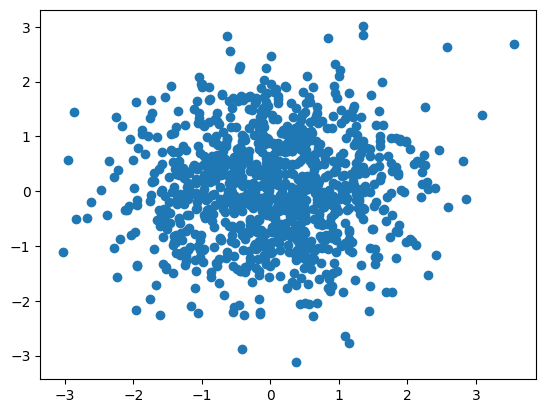

In [5]:
plt.scatter(white_data[:, 0], white_data[:, 1])

For eigenvectors and eigenvalues of a matrix $A$ it is true that 

$$A v = \lambda v$$

where $v$ is an eigenvector and $\lambda$ is a corresponding eigenvalue

In [6]:
cov = [[3, 2], [2, 3]]
eigenvalues, eigenvectors = np.linalg.eig(cov)

v = eigenvectors[:, 0]
lambd = eigenvalues[0]

lhs = cov @ v 
rhs = lambd * v

print(f"LHS = {lhs}")
print(f"RHS = {rhs}")
print(np.allclose(lhs, rhs))

LHS = [3.53553391 3.53553391]
RHS = [3.53553391 3.53553391]
True


If we have white data $D$ defined as above, then we can apply a transformation $T$ consisting of rotation $R$ and scaling $S$ ($T = RS$) to get new data $D'$. It relates covariance matrix as follows $$\Sigma = TIT^{T}$$ $$\Sigma = RS(RS)^{T}$$ $$\Sigma = RSS^TR^T$$

How does it relate to eigenvalues & eigenvectors?

$$\Sigma V = V L$$ where $V$ is a matrix of eigenvectors and $L$ is a diagonal matrix of eigenvalues

$$\Sigma = V L V^{-1}$$

It is the eigendecomposition of the covariance matrix, where $R = V$ and $S = \sqrt{L}$

In [7]:
cov = [[3, 2], [2, 3]]
eigenvalues, eigenvectors = np.linalg.eig(cov)

In [8]:
eigenvalues

array([5., 1.])

In [9]:
eigenvectors

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [10]:
R = eigenvectors
S = np.sqrt(np.diag(eigenvalues))
print(R)
print(S)
new_cov = R @ S @ S.T @ R.T
print(new_cov)
np.allclose(new_cov, cov) # same as original one

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[[2.23606798 0.        ]
 [0.         1.        ]]
[[3. 2.]
 [2. 3.]]


True

In [11]:
U, M, V = LA.svd(cov)
M = np.sqrt(np.diag(M))

In [12]:
print(U)
print(M)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[[2.23606798 0.        ]
 [0.         1.        ]]


In [13]:
np.allclose(new_cov, cov) # same as original one

True

In [14]:
transformed_data = white_data @ S @ R.T

In [15]:
transformed_data

array([[ 0.39057637,  0.06583624],
       [ 0.21440855, -0.8362376 ],
       [-0.39643434,  1.0787221 ],
       ...,
       [ 4.10493567,  1.5076817 ],
       [ 0.01075581, -0.88042093],
       [-0.30776014,  0.34113286]])

In [16]:
data = np.random.multivariate_normal(mean=[0, 0], cov=cov, size=1000)

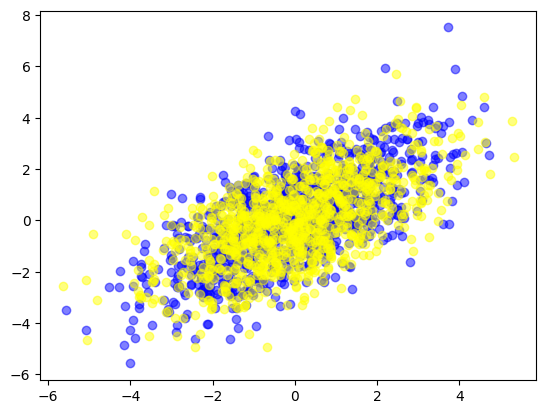

In [17]:
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5, color='blue')
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='yellow')

### Projecting 3D Covariance onto 2D 

In general, if we want to apply $V$ transformation to a covariance matrix $\Sigma$, then 

$$\Sigma' = V \Sigma V^{T}$$

In [18]:
scene_folder = Path('../data/south-building')
images_folder = scene_folder / 'images'
database_path = scene_folder / 'database.db'

reconstruction = pycolmap.Reconstruction(scene_folder / '0')
camera = reconstruction.cameras[1]
img_id = 60
img = reconstruction.images[img_id]
img_name = img.name

In [19]:
width, height = camera.width, camera.height

In [20]:
img_points, colors = projection_from_reconstruction(reconstruction, img_id)
points, colors = filter_view_points(img_points, colors, width, height)

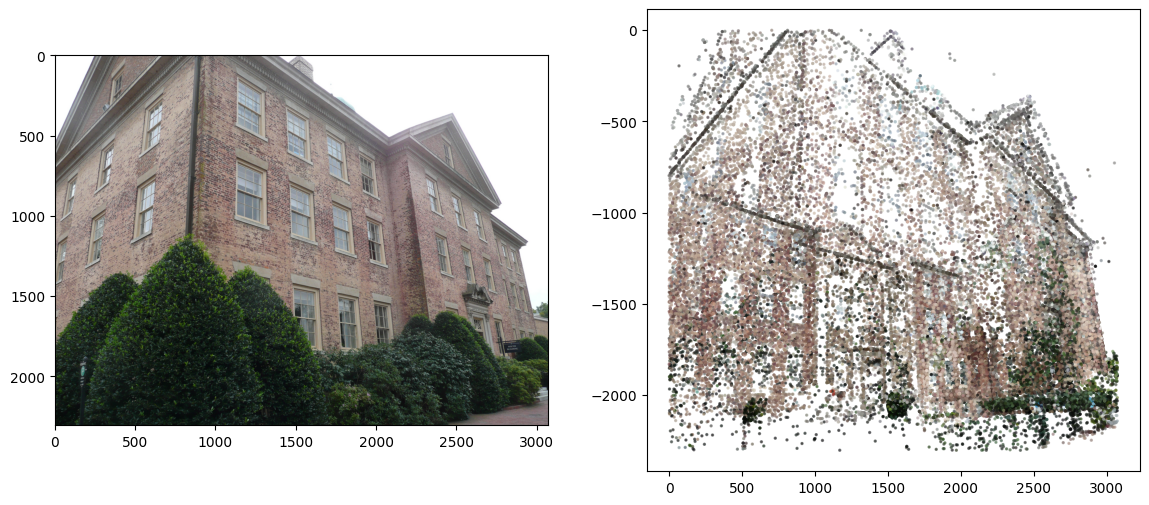

In [21]:
image = mpimg.imread(images_folder / f'{img_name}')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.scatter(points[:, 0], -points[:, 1], alpha=0.5, c=colors, s=2)

In [48]:
image

array([[[250, 255, 254],
        [250, 255, 254],
        [250, 255, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[250, 255, 254],
        [250, 255, 254],
        [250, 255, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[250, 255, 254],
        [250, 255, 254],
        [250, 255, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  7,  20,  13],
        [  7,  20,  13],
        [  7,  19,  15],
        ...,
        [128, 109, 111],
        [123, 107, 108],
        [123, 107, 108]],

       [[  6,  19,  12],
        [  6,  19,  12],
        [  7,  20,  13],
        ...,
        [129, 113, 114],
        [124, 108, 109],
        [123, 107, 108]],

       [[  5,  18,   9],
        [  6,  19,  10],
        [  7,  20,  13],
        ...,
        [137, 123, 123],
        [132, 118, 118],
        [131, 117, 117]]

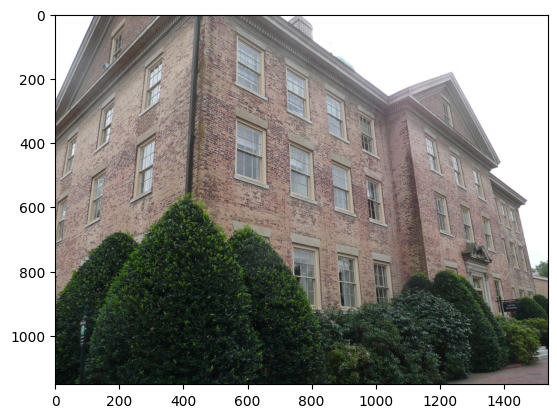

In [56]:
downscaled = downscale_local_mean(image, (2, 2, 1)).astype(np.uint8)
plt.imshow(downscaled)

In [57]:
downscaled.shape

(1152, 1536, 3)

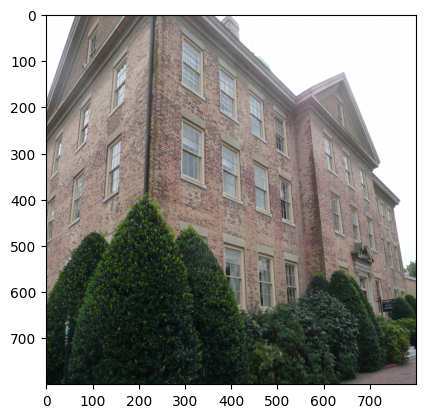

In [64]:
plt.imshow(resize(downscaled, (800, 800)))

In [22]:
extrinsic_params = get_extrinsic_params(get_camera_from_image(img))
print(extrinsic_params)

[[ 0.65883531 -0.16565849 -0.73382103  1.29975755]
 [ 0.21772808  0.97569481 -0.02478149  1.12463341]
 [ 0.72009063 -0.14344652  0.6788907   3.4804925 ]
 [ 0.          0.          0.          1.        ]]


In [23]:
viewing_transformation = extrinsic_params[:3, :3] # LA.inv(extrinsic_params[:3, :3])
viewing_transformation

array([[ 0.65883531, -0.16565849, -0.73382103],
       [ 0.21772808,  0.97569481, -0.02478149],
       [ 0.72009063, -0.14344652,  0.6788907 ]])

In [24]:
cov3D = np.array([[1, 2, 3], [2, 3, 2], [1, 1, 1]])

Viewing transformation is used to transform from object space to camera coordinates

In [25]:
variance_in_camera_coordinates = viewing_transformation @ cov3D @ viewing_transformation.T
variance_in_camera_coordinates

array([[-0.95085894, -0.02628593,  0.31368265],
       [-1.03326961,  3.65958533,  2.81672352],
       [-1.41997889,  1.82657123,  2.29127361]])

### Perspective Projection

In perspective projection, a 3D point in a truncated pyramid frustum (eye coordinates) is mapped to a cube (NDC).

<div>
<img src="images/gl_projectionmatrix01.png" width="500">
</div>

A 3D point is projected onto **near** plane in eye space (2D). The following show how point $(x_e, y_e, z_e)$ is projected to $(x_p, y_p, z_p)$ on the near space.

<div>
<img src="images/gl_projectionmatrix03.png" width="500">
<img src="images/gl_projectionmatrix04.png" width="500">
</div>

Using the ratio of similar triangles, we calculate:

$$x_p = \frac{n * x_e}{-z_e}$$
$$y_p = \frac{n * y_e}{-z_e}$$
$$z_p = -n$$

However, this transformation can't be represented by 3x3 matrix so we'll need to use it's approximation. We'll need to find Jacobian matrix 

$$ J = \begin{pmatrix}
 \frac{x_p}{x_e} & \frac{y_p}{x_e} & \frac{z_p}{x_e} \\
 \frac{x_p}{y_e} & \frac{y_p}{y_e} & \frac{z_p}{y_e} \\
 \frac{x_p}{z_e} & \frac{y_p}{z_e} & \frac{z_p}{z_e} 
 \end{pmatrix}
 $$
 
$$J = \begin{pmatrix} 
\frac{-n}{z_e} & 0 & 0 \\
0 & -\frac{n}{z_e} & 0 \\
\frac{nx_e}{z_e^{2}} & \frac{ny_e}{z_e^{2}} & 0
\end{pmatrix}$$

In [26]:
def get_jacobian_matrix(point: np.array, znear):
    J = np.zeros((3, 3))
    J[0, 0] = -znear / point[2]
    J[1, 1] = -znear / point[2]
    J[2, 0] = point[0] / point[2] ** 2
    J[2, 1] = point[1] / point[2] ** 2
    return J 

In [27]:
homogenous_points = convert_to_homogenous(get_points_xyz(reconstruction)).T
projected_to_camera_viewpoint = (extrinsic_params @ homogenous_points).T

In [28]:
jac = get_jacobian_matrix(projected_to_camera_viewpoint[0, :3], 0.1)

In [29]:
jac

array([[-0.03228303,  0.        ,  0.        ],
       [ 0.        , -0.03228303,  0.        ],
       [ 0.15443729,  0.05212275,  0.        ]])

In [30]:
cov = np.array([[3, 1, 1], [0, 3, 0], [1, 1, 3]])

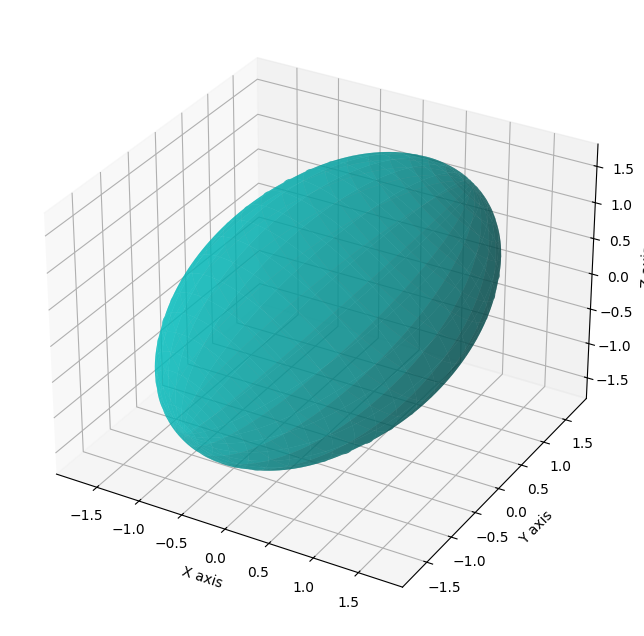

In [31]:
# Generated by chatgpt
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Compute eigenvalues and eigenvectors of the covariance matrix
eigvals, eigvecs = np.linalg.eigh(cov)

# Step 3: Generate a sphere
# Create a grid of points that forms a unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# Stack the sphere points into a 3xN array (for matrix multiplication)
sphere_points = np.stack((x, y, z), axis=0).reshape(3, -1)

# Step 4: Transform the unit sphere into the ellipsoid using the covariance matrix
# Scale the sphere points by the eigenvalues and rotate them using the eigenvectors
ellipsoid_points = eigvecs @ np.diag(np.sqrt(eigvals)) @ sphere_points

# Reshape to 3D for plotting
x_ellipsoid = ellipsoid_points[0, :].reshape(100, 100)
y_ellipsoid = ellipsoid_points[1, :].reshape(100, 100)
z_ellipsoid = ellipsoid_points[2, :].reshape(100, 100)

# Step 5: Plot the ellipsoid
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface of the ellipsoid
ax.plot_surface(x_ellipsoid, y_ellipsoid, z_ellipsoid, color='c', alpha=0.6, rstride=4, cstride=4, linewidth=0.5)

# Add labels and set equal aspect ratio
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()

In [32]:
projected_cov = jac @ viewing_transformation @ cov @ viewing_transformation.T @ jac.T

In [33]:
projected_cov[:2, :2]

array([[ 0.00213179, -0.00025978],
       [-0.00021684,  0.00331154]])

C:\Users\julia\AppData\Local\Temp\ipykernel_23692\544659166.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=[0, 0], cov=projected_cov[:2, :2], size=1000)


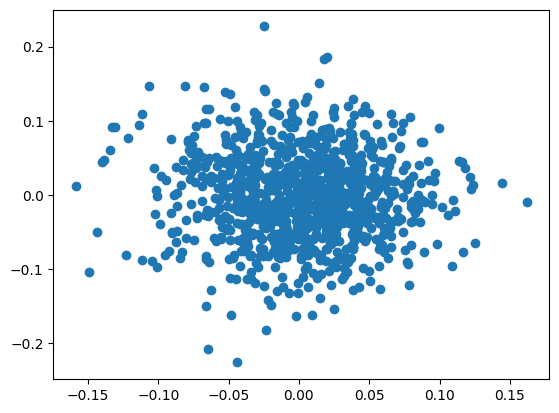

In [34]:
data = np.random.multivariate_normal(mean=[0, 0], cov=projected_cov[:2, :2], size=1000)
plt.scatter(data[:, 0], data[:, 1])

In [35]:
eigenvalues, eigenvectors = LA.eig(projected_cov[:2, :2])

In [36]:
eigenvalues, eigenvectors

(array([0.00208584, 0.00335749]),
 array([[-0.98470885,  0.20733931],
        [-0.17420817, -0.97826909]]))

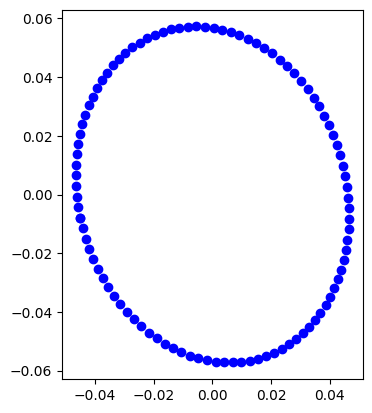

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Define the circle parameters
r = 1  # radius
theta = np.linspace(0, 2 * np.pi, 100)  # 100 points between 0 and 2pi

# Parametric equations for the circle
x = r * np.cos(theta)
y = r * np.sin(theta)

sphere_points = np.stack((x, y), axis=0).reshape(2, -1)
sphere_points = (eigenvectors @ np.diag(np.sqrt(eigenvalues)) @ sphere_points).T

# Use plt.scatter to plot the circle points
plt.scatter(sphere_points[:, 0], sphere_points[:, 1], color='blue')

# Set the aspect ratio to equal to ensure the circle isn't distorted
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()


In [38]:
sphere_points[:2]

array([[-0.04497259, -0.00795625],
       [-0.04412007, -0.0115354 ]])